# Evaluación de importancia de cada predictor bioquímico global

## Vamos a ver cómo afecta cada predictor bioquímico por separado al rendimiento del modelo AMP-BERT-BIOCHEM

In [1]:
import pandas as pd
import torch

SEED = 0
FRAC_VAL = 0.2

torch.manual_seed(SEED)

train_df = pd.read_csv('./datasets/all_veltri_2.csv', index_col = 0).sample(frac=1, random_state=SEED)
df_pos = pd.read_csv('./datasets/veltri_dramp_cdhit_90_2.csv', index_col = 0)
df_neg = pd.read_csv('./datasets/non_amp_ampep_cdhit90_2.csv', index_col = 0)

val_df_pos = df_pos.sample(frac=FRAC_VAL, random_state=SEED)
val_df_neg = df_neg.sample(frac=FRAC_VAL, random_state=SEED)
test_df_pos = df_pos.drop(val_df_pos.index)
test_df_neg = df_neg.drop(val_df_neg.index)

val_df = pd.concat([val_df_pos, val_df_neg]).sample(frac=1, random_state=SEED)
test_df = pd.concat([test_df_pos, test_df_neg]).sample(frac=1, random_state=SEED)

print(f"Validation dataframe: {len(val_df_pos)} positives, {len(val_df_neg)} negatives ({len(val_df_pos)/len(val_df)}%)")
print(f"Test dataframe: {len(test_df_pos)} positives, {len(test_df_neg)} negatives ({len(test_df_pos)/len(test_df)}%)")

Validation dataframe: 413 positives, 382 negatives (0.519496855345912%)
Test dataframe: 1652 positives, 1526 negatives (0.5198237885462555%)


In [2]:
from pipeline_tools import AMP_BioChemDataLoader, train_model, eval_model, compute_metrics
from torch.optim import AdamW
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from MultiGPUModels import MultiGPUBertForPeptideClassification
import torch
from torch.nn import CrossEntropyLoss
from copy import deepcopy

BATCH_SIZE = 8
LEARNING_RATE = 5e-6
WEIGHT_DECAY = 0.01
EPOCHS = 1
            
biochem_cols = [
    "molecular_mass",
    "hydrophobic_freq",
    "hydrophilic_freq",
    "basic_freq",
    "acid_freq",
    "charge",
    "aliphatic_index",
    "average_hydrophobicity",
    "isoelectric_point"
]


bert_model = BertForSequenceClassification.from_pretrained('Rostlab/prot_bert_bfd')


Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not init

In [3]:
def train_with_cols(biochem_cols):
    train_dataloader = AMP_BioChemDataLoader(train_df, biochem_cols, batch_size = BATCH_SIZE)            
    test_dataloader = AMP_BioChemDataLoader(test_df, biochem_cols, batch_size = BATCH_SIZE)            

    multi_gpu_bert_pred = MultiGPUBertForPeptideClassification(bert_model, biochem_cols)
            
    # Entrenar el modelo con esta configuracion
    optimizer = AdamW(
        multi_gpu_bert_pred.parameters(), 
        lr = LEARNING_RATE, 
        weight_decay = WEIGHT_DECAY)
            
    total_steps = len(train_dataloader) * EPOCHS
            
    scheduler = get_linear_schedule_with_warmup(optimizer, 
        num_warmup_steps = 0, 
        num_training_steps = total_steps)

    for i in range(EPOCHS):
        train_model(multi_gpu_bert_pred, train_dataloader, CrossEntropyLoss(), optimizer, scheduler, True)
            
    # Obtener las métricas de validacion
    test_labels, test_preds = eval_model(multi_gpu_bert_pred, test_dataloader, CrossEntropyLoss(), True)
    test_metrics = compute_metrics(test_labels, test_preds)

    print(f"Metrics for test set: ")
    print(test_metrics)
    
    del multi_gpu_bert_pred
    return test_metrics
    
            
    

In [ ]:

for i in range(5):
    test_metrics_no_biochem = train_with_cols([])
    test_metrics_no_biochem.to_csv(f'./biochem_results/test_metrics_no_biochem({i}).csv')

    for biochem_pred in biochem_cols:
        test_metrics_pred = train_with_cols([biochem_pred])
        test_metrics_pred.to_csv(f'./biochem_results/test_metrics_only_pred_{biochem_pred}({i}).csv')

In [ ]:
for i in range(5):
    test_metrics_all_biochem = train_with_cols(biochem_cols)
    test_metrics_all_biochem.to_csv(f'./biochem_results/test_metrics_all_biochem({i}).csv')

In [105]:
import pandas as pd


pred_metrics = {}
samples = []

all_preds = pd.read_csv("./biochem_results/test_metrics_with_biochem_1ep.csv").mean()
pred_metrics["all_preds"] = all_preds  

for i in range(5):
    test_metrics_no_pred = pd.read_csv(f'./biochem_results/test_metrics_no_biochem({i}).csv')
    samples.append(test_metrics_pred)
    
pred_metrics["no_pred"] = pd.concat(samples).mean()
for biochem_pred in biochem_cols:

    samples = []
    
    for i in range(5):
        test_metrics_pred = pd.read_csv(f'./biochem_results/test_metrics_only_pred_{biochem_pred}({i}).csv')
        samples.append(test_metrics_pred)
    
    pred_metrics[biochem_pred] = pd.concat(samples).mean()

metrics_df = pd.DataFrame(pred_metrics, index=None).transpose()

print(metrics_df)

                        Unnamed: 0  accuracy        f1  precision    recall  \
all_preds                      0.0  0.796728  0.812427   0.780692  0.846852   
no_pred                        0.0  0.737760  0.774988   0.703451  0.864891   
molecular_mass                 0.0  0.756639  0.788131   0.720156  0.870581   
hydrophobic_freq               0.0  0.735683  0.775096   0.696713  0.874334   
hydrophilic_freq               0.0  0.727313  0.768689   0.688777  0.870460   
basic_freq                     0.0  0.726558  0.767873   0.688290  0.868886   
acid_freq                      0.0  0.725677  0.767111   0.686734  0.868886   
charge                         0.0  0.733040  0.771570   0.695235  0.866949   
aliphatic_index                0.0  0.732599  0.771758   0.694809  0.868523   
average_hydrophobicity         0.0  0.726054  0.768367   0.687984  0.871550   
isoelectric_point              0.0  0.738704  0.775267   0.703316  0.864770   

                        specificity     auroc      

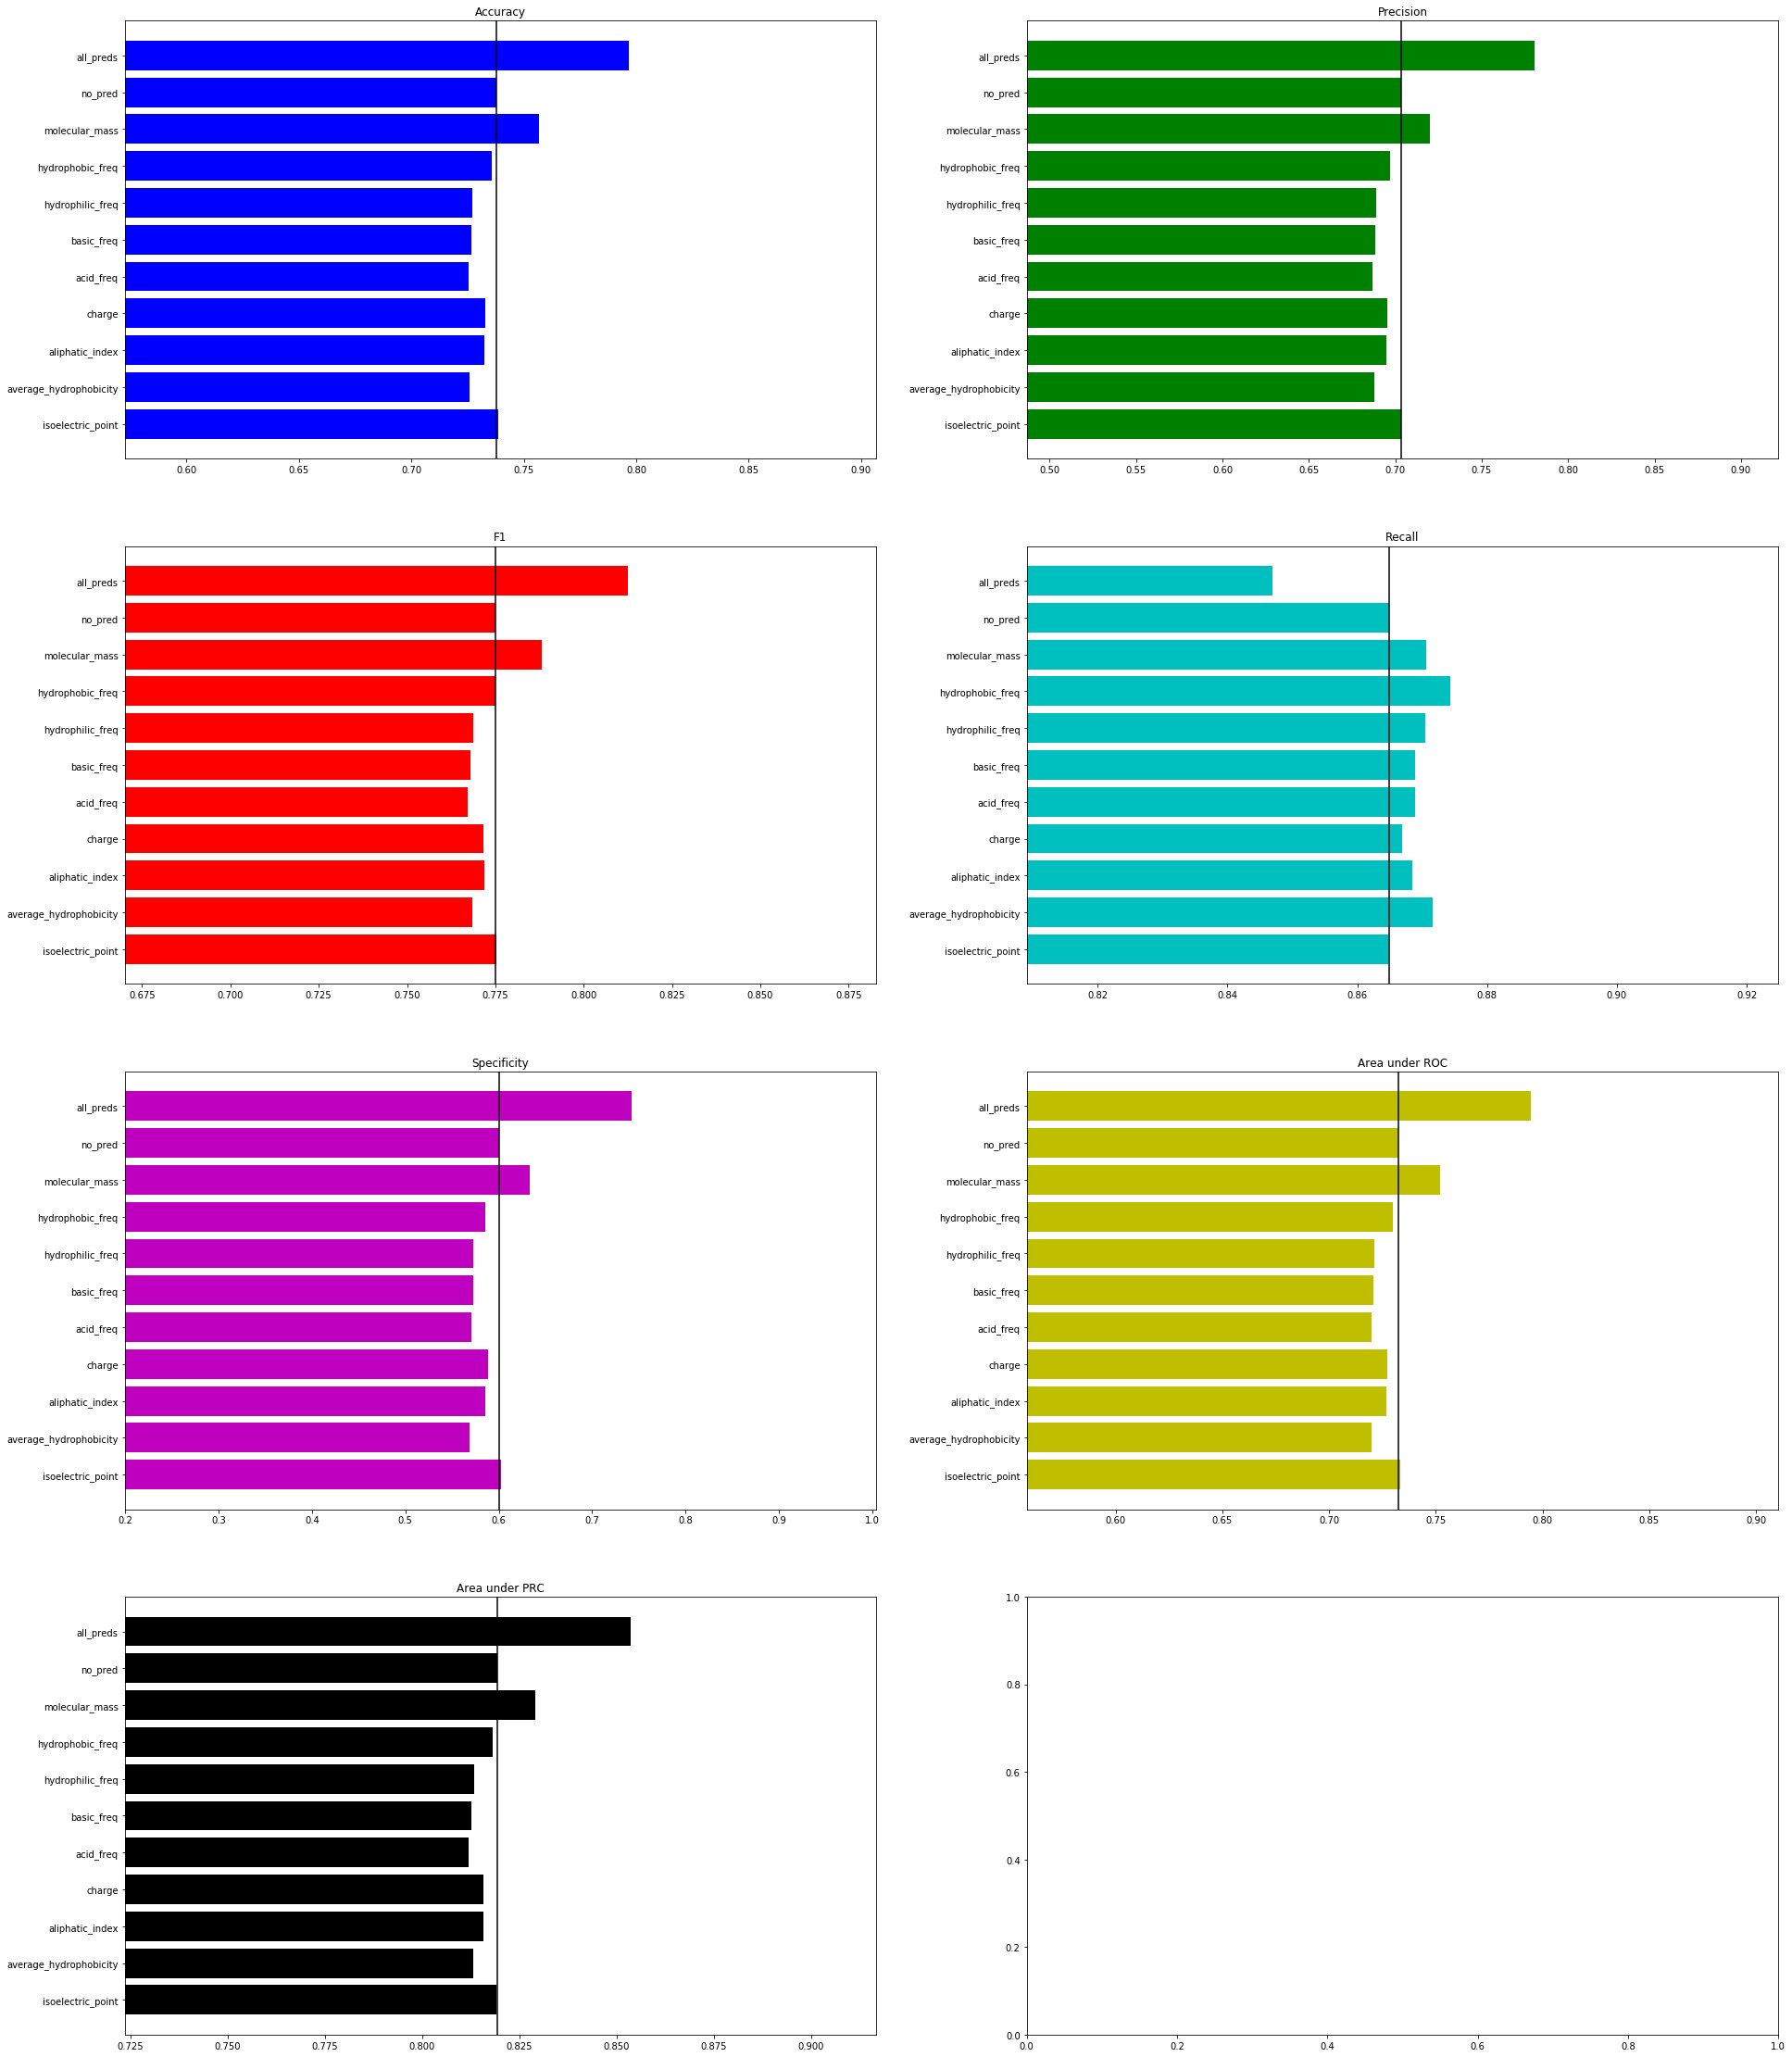

In [106]:
import numpy as np
import matplotlib.pyplot as plt 

index = np.arange(len(metrics_df["accuracy"]))
tags = ["all_preds", "no_pred"] + biochem_cols

fig, axs = plt.subplots(4,2, figsize=(32, 40))

w = 0.8
C = 8

axs[0][0].barh(index, metrics_df["accuracy"], color='b')
axs[0][0].set_title("Accuracy")
axs[0][0].set_yticks(index)
axs[0][0].set_yticklabels(tags) # 0.7,0.775
mean = metrics_df["accuracy"].mean()
std = metrics_df["accuracy"].std()
axs[0][0].set_xlim(mean-C*std,mean+C*std)
axs[0][0].axvline(x = metrics_df["accuracy"]["no_pred"], color = 'k')
axs[0][0].invert_yaxis()  # labels read top-to-bottom

axs[0][1].barh(index, metrics_df["precision"], color='g')
axs[0][1].set_title("Precision")
axs[0][1].set_yticks(index)
axs[0][1].set_yticklabels(tags)
mean = metrics_df["precision"].mean()
std = metrics_df["precision"].std()
axs[0][1].set_xlim(mean-C*std,mean+C*std)
axs[0][1].axvline(x = metrics_df["precision"]["no_pred"], color = 'k')
axs[0][1].invert_yaxis()  # labels read top-to-bottom

axs[1][0].barh(index, metrics_df["f1"], color='r')
axs[1][0].set_title("F1")
axs[1][0].set_yticks(index)
axs[1][0].set_yticklabels(tags)
mean = metrics_df["f1"].mean()
std = metrics_df["f1"].std()
axs[1][0].set_xlim(mean-C*std,mean+C*std)
axs[1][0].axvline(x = metrics_df["f1"]["no_pred"], color = 'k')
axs[1][0].invert_yaxis()  # labels read top-to-bottom

axs[1][1].barh(index, metrics_df["recall"], color='c')
axs[1][1].set_title("Recall")
axs[1][1].set_yticks(index)
axs[1][1].set_yticklabels(tags)
mean = metrics_df["recall"].mean()
std = metrics_df["recall"].std()
axs[1][1].set_xlim(mean-C*std,mean+C*std)
axs[1][1].axvline(x = metrics_df["recall"]["no_pred"], color = 'k')
axs[1][1].invert_yaxis()  # labels read top-to-bottom

axs[2][0].barh(index, metrics_df["specificity"], color='m')
axs[2][0].set_title("Specificity")
axs[2][0].set_yticks(index)
axs[2][0].set_yticklabels(tags)
mean = metrics_df["specificity"].mean()
std = metrics_df["specificity"].std()
axs[2][0].set_xlim(mean-C*std,mean+C*std)
axs[2][0].axvline(x = metrics_df["specificity"]["no_pred"], color = 'k')
axs[2][0].invert_yaxis()  # labels read top-to-bottom

axs[2][1].barh(index, metrics_df["auroc"], color='y')
axs[2][1].set_title("Area under ROC")
axs[2][1].set_yticks(index)
axs[2][1].set_yticklabels(tags)
mean = metrics_df["auroc"].mean()
std = metrics_df["auroc"].std()
axs[2][1].set_xlim(mean-C*std,mean+C*std)
axs[2][1].axvline(x = metrics_df["auroc"]["no_pred"], color = 'k')
axs[2][1].invert_yaxis()  # labels read top-to-bottom

axs[3][0].barh(index, metrics_df["aupr"], color='k')
axs[3][0].set_title("Area under PRC")
axs[3][0].set_yticks(index)
axs[3][0].set_yticklabels(tags)
mean = metrics_df["aupr"].mean()
std = metrics_df["aupr"].std()
axs[3][0].set_xlim(mean-C*std,mean+C*std)
axs[3][0].axvline(x = metrics_df["aupr"]["no_pred"], color = 'k')
axs[3][0].invert_yaxis()  # labels read top-to-bottom


##############



plt.show()